<center>
<h1> Linear Regression Case Study
</center>

### Steps for Regression Modeling:
1. Business problem definition - One of major automobile company would like to design new product which can improve the sales. Inorder to define the product, they want to understand/identify drivers for the sales (what are the factors driving sales) and Predicting sales of different car models given driving factors. 
2. Convert business problem into statistical problem  sales = F(sales attributes, product features, marketing info etc.)
3. Finding the right technique - Since it is predicting value (Regression Problem) problem so we can use OLS as one of the technique. We can also use other techniques like Decision Trees, Ensemble learning, KNN, SVM, ANN etc.
4. Data colletion(Y, X) - Identify the sources of information and collect the data
5. Consolidate the data - aggregate and consolidate the data at Model level/customer level/store level depends on business problem
6. Data preparation for modeling (create data audit report to identify the steps to perform as part of data preparation)
    a. missing value treatment
    b. outlier treatment
    c. dummy variable creation
7. Variable creation by using transformation and derived variable creation.
8. Basic assumptions (Normality, linearity, no outliers, homoscadasticity, no pattern in residuals, no auto correlation etc)
9. Variable reduction techniques (removing multicollinerity with the help of FA/PCA, correlation matrics, VIF)
10. Create dev and validation data sets (50:50 if you have more data else 70:30 or 80:20)
11. Modeling on dev data set (identify significant variables, model interpretation, check the signs and coefficients, multi-collinierity check, measures of good neess fit, final mathematical equation etc)
12. validating on validation data set (check the stability of model, scoring, decile analysis, cross validation etc.)
13. Output interpretation and derive insights (understand the limitations of the model and define strategy to implementation)
14. convert statistical solution into business solutions (implementation, model monitoring etc)


### import the packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

In [ ]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# from sklearn.linear_model import LinearRegression
# sklearn - scikit learn

### create UDFs

In [ ]:
def continuous_var_summary( x ):
    
    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total
    
    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr
    
    return pd.Series( [ x.dtype, x.nunique(), n_total, x.count(), n_miss, perc_miss,
                       x.sum(), x.mean(), x.std(), x.var(), 
                       lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max() ], 
                     
                    index = ['dtype', 'cardinality', 'n_tot', 'n', 'nmiss', 'perc_miss',
                             'sum', 'mean', 'std', 'var',
                        'lc_iqr', 'uc_iqr',
                        'min', 'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'max']) 

In [ ]:
# Create Data audit Report for categorical variables
def categorical_var_summary( x ):
    
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100 / x.count(), 2)], 
                     
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [ ]:
# Missing value imputation for continuous variables
def missing_imputation( x, stats = 'mean' ):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    return x

In [ ]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

### import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Data Sets/"

cars = pd.read_csv(path + 'Car.csv')

cars

,Manufacturer,Model,Sales,four_year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,02-02-2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,06-03-2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,01-04-2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,03-10-2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10-08-2011,62.777639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Volvo,V40,3.545,NaN,Passenger,24.40,1.9,160.0,100.5,67.6,176.6,3.042,15.8,25.0,9/21/2011,66.498812
153,Volvo,S70,15.245,NaN,Passenger,27.50,2.4,168.0,104.9,69.3,185.9,3.208,17.9,25.0,11/24/2012,70.654495
154,Volvo,V70,17.531,NaN,Passenger,28.80,2.4,168.0,104.9,69.3,186.2,3.259,17.9,25.0,6/25/2011,71.155978
155,Volvo,C70,3.493,NaN,Passenger,45.50,2.3,236.0,104.9,71.5,185.7,3.601,18.5,23.0,4/26/2011,101.623357


### Data inspection

In [ ]:
cars.nunique()

Manufacturer               30
Model                     156
Sales                     157
four_year_resale_value    117
Vehicle_type                2
Price_in_thousands        152
Engine_size                31
Horsepower                 66
Wheelbase                  88
Width                      78
Length                    127
Curb_weight               147
Fuel_capacity              55
Fuel_efficiency            20
Latest_Launch             130
Power_perf_factor         154
dtype: int64

In [ ]:
# method 1: divide the data into training and testing
train, test = train_test_split( cars, test_size = 0.2, random_state = 12345 )
print(train.shape)
print(test.shape)

(125, 16)
(32, 16)


In [ ]:
train.rename(columns={'Sales_in_thousands': 'Sales'}, inplace=True)
print(train.shape)
train

(125, 16)


,Manufacturer,Model,Sales,four_year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
95,Mercedes-B,SL-Class,3.311,58.600,Passenger,82.600,5.0,302.0,99.0,71.3,177.1,4.125,21.1,20.0,3/17/2011,139.982294
146,Volkswagen,Jetta,83.721,13.240,Passenger,16.700,2.0,115.0,98.9,68.3,172.3,2.853,14.5,26.0,8/27/2011,47.638237
65,Infiniti,I30,23.713,19.690,Passenger,29.465,3.0,227.0,108.3,70.2,193.7,3.342,18.5,25.0,4/15/2012,92.436889
99,Mercedes-B,CL500,0.954,NaN,Passenger,85.500,5.0,302.0,113.6,73.1,196.6,4.115,23.2,20.0,4/11/2011,141.100985
122,Pontiac,Bonneville,35.945,13.225,Passenger,23.755,3.8,205.0,112.2,72.6,202.5,3.590,17.5,24.0,5/18/2011,82.661356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,Chrysler,300M,30.696,NaN,Passenger,29.185,3.5,253.0,113.0,74.4,197.8,3.567,17.0,23.0,2/10/2012,101.655244
101,Nissan,Sentra,42.643,8.450,Passenger,13.499,1.8,126.0,99.8,67.3,177.5,2.593,13.2,30.0,8/31/2011,50.241978
126,Porsche,Carrera Cabrio,1.866,67.550,Passenger,74.970,3.4,300.0,92.6,69.5,174.5,3.075,17.0,23.0,7/11/2011,135.914710
129,Saturn,SL,80.620,9.200,Passenger,10.685,1.9,100.0,102.4,66.4,176.9,2.332,12.1,33.0,8/16/2012,39.986425


In [ ]:
test.rename(columns={'Sales_in_thousands': 'Sales'}, inplace=True)
print(test.shape)
test

(32, 16)


,Manufacturer,Model,Sales,four_year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
70,Lexus,ES300,24.072,26.975,Passenger,31.505,3.0,210.0,105.1,70.5,190.2,3.373,18.5,23.0,7/9/2012,87.211001
42,Dodge,Ram Van,31.038,13.425,Car,18.575,3.9,175.0,127.2,78.8,208.5,4.298,32.0,16.0,7/26/2012,70.078322
56,Ford,F-Series,540.561,15.075,Car,26.935,4.6,220.0,138.5,79.1,224.5,4.241,25.1,18.0,8/16/2012,89.401935
35,Dodge,Neon,76.034,7.750,Passenger,12.640,2.0,132.0,105.0,74.4,174.4,2.567,12.5,29.0,12/12/2011,52.084899
16,Cadillac,Eldorado,6.536,25.725,Passenger,39.665,4.6,275.0,108.0,75.5,200.6,3.843,19.0,22.0,11/27/2011,113.765874
24,Chevrolet,Corvette,17.947,36.225,Passenger,45.705,5.7,345.0,104.5,73.6,179.7,3.210,19.1,22.0,5/12/2012,141.141150
132,Saturn,LW,8.472,NaN,Passenger,18.835,2.2,137.0,106.5,69.0,190.4,3.075,13.1,27.0,8/5/2011,56.295243
10,Buick,Century,91.561,12.475,Passenger,21.975,3.1,175.0,109.0,72.7,194.6,3.368,17.5,25.0,11/2/2011,71.181451
140,Toyota,Tacoma,84.087,9.575,Car,11.528,2.4,142.0,103.3,66.5,178.7,2.580,15.1,23.0,8/1/2011,55.297117
86,Mercury,Mystique,14.351,8.800,Passenger,16.240,2.0,125.0,106.5,69.1,184.8,2.769,15.0,28.0,12/19/2012,50.997748


In [ ]:
cars.columns

Index(['Manufacturer', 'Model', 'Sales_in_thousands', 'four_year_resale_value',
       'Vehicle_type', 'Price_in_thousands', 'Engine_size', 'Horsepower',
       'Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity',
       'Fuel_efficiency', 'Latest_Launch', 'Power_perf_factor'],
      dtype='object')

In [ ]:
cars.shape

(157, 16)

In [ ]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Manufacturer            157 non-null    object 
 1   Model                   157 non-null    object 
 2   Sales_in_thousands      157 non-null    float64
 3   four_year_resale_value  121 non-null    float64
 4   Vehicle_type            157 non-null    object 
 5   Price_in_thousands      155 non-null    float64
 6   Engine_size             156 non-null    float64
 7   Horsepower              156 non-null    float64
 8   Wheelbase               156 non-null    float64
 9   Width                   156 non-null    float64
 10  Length                  156 non-null    float64
 11  Curb_weight             155 non-null    float64
 12  Fuel_capacity           156 non-null    float64
 13  Fuel_efficiency         154 non-null    float64
 14  Latest_Launch           157 non-null    ob

In [ ]:
cars.head()

,Manufacturer,Model,Sales_in_thousands,four_year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [ ]:
# no of unique values / cardinality
cars.nunique()

Manufacturer               30
Model                     156
Sales_in_thousands        157
four_year_resale_value    117
Vehicle_type                2
Price_in_thousands        152
Engine_size                31
Horsepower                 66
Wheelbase                  88
Width                      78
Length                    127
Curb_weight               147
Fuel_capacity              55
Fuel_efficiency            20
Latest_Launch             130
Power_perf_factor         154
dtype: int64

In [ ]:
cars.Vehicle_type.value_counts()

Passenger    116
Car           41
Name: Vehicle_type, dtype: int64

In [ ]:
# type conversion in case variables are not of proper type : Not required in this data

In [ ]:
# in case we have huge data and we dont want to make the copy of the original data 
# we generally go with the option of getting column/variable names for obejat and numeric type

numeric_columns = cars.select_dtypes(include = ['float64', 'int64']).columns
object_columns = cars.select_dtypes(include = ['object']).columns

In [ ]:
cars[ object_columns ].head(2)

,Manufacturer,Model,Vehicle_type,Latest_Launch
0,Acura,Integra,Passenger,2/2/2012
1,Acura,TL,Passenger,6/3/2011


In [ ]:
cars[ numeric_columns ].head(2)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
0,16.919,16.360,21.5,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,58.280150
1,39.384,19.875,28.4,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,91.370778


## or

In [ ]:
# seperate object and numeric variables
cars_conti_vars = cars.loc[:, (cars.dtypes == 'float64') | (cars.dtypes == 'int64')]
cars_cat_vars = cars.loc[:, (cars.dtypes == 'object')]

# Simper way of doing:
# cars_conti_vars = cars.select_dtypes(include = ['float64', 'int64'])
# car_sales_cat = cars.select_dtypes(include = ['object'])

In [ ]:
# alternate of .describe() for continuous variables
cars_conti_vars.apply( continuous_var_summary )

# cars_conti_vars.apply( lambda x: continuous_var_summary(x)).round(1)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,157,117,152,31,66,88,78,127,147,55,20,154
n_tot,157,157,157,157,157,157,157,157,157,157,157,157
n,157,121,155,156,156,156,156,156,155,156,154,155
nmiss,0,36,2,1,1,1,1,1,2,1,3,2
perc_miss,0.0,22.929936,1.273885,0.636943,0.636943,0.636943,0.636943,0.636943,1.273885,0.636943,1.910828,1.273885
sum,8320.698,2186.83,4245.567,477.5,29008.0,16768.0,11099.4,29225.6,523.594,2800.5,3672.0,11941.756636
mean,52.998076,18.072975,27.390755,3.060897,185.948718,107.487179,71.15,187.34359,3.378026,17.951923,23.844156,77.043591
std,68.029422,11.453384,14.351653,1.044653,56.700321,7.641303,3.451872,13.431754,0.630502,3.887921,4.282706,25.142664
var,4628.002257,131.180007,205.969949,1.0913,3214.926385,58.389512,11.915419,180.412023,0.397532,15.115932,18.341567,632.153558


In [ ]:
# alternate of .describe() for categorical variables
cars_cat_vars.apply(categorical_var_summary).T

,N,NMISS,MODE,FREQ,PERCENT
Manufacturer,157,0,Dodge,11,7.01
Model,157,0,Neon,2,1.27
Vehicle_type,157,0,Passenger,116,73.89
Latest_Launch,157,0,5/31/2011,2,1.27


### outlier treatment

In [ ]:
cars_conti_vars = cars_conti_vars.apply( lambda x: x.clip(lower = x.quantile(0.01),
                                                         upper = x.quantile(0.99)))

In [ ]:
cars_conti_vars.apply(continuous_var_summary)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,155,115,150,29,64,87,76,125,145,54,19,152
n_tot,157,157,157,157,157,157,157,157,157,157,157,157
n,157,121,155,156,156,156,156,156,155,156,154,155
nmiss,0,36,2,1,1,1,1,1,2,1,3,2
perc_miss,0.0,22.929936,1.273885,0.636943,0.636943,0.636943,0.636943,0.636943,1.273885,0.636943,1.910828,1.273885
sum,8025.5292,2180.421,4235.95548,475.81,28910.3,16760.1,11102.45,29223.94,523.77016,2799.9,3660.0,11911.685368
mean,51.11802,18.020008,27.328745,3.050064,185.322436,107.436538,71.169551,187.332949,3.379162,17.948077,23.766234,76.849583
std,57.722699,11.181335,14.06397,0.982279,52.81647,7.424295,3.390339,13.12035,0.621764,3.819854,3.994755,23.844968
var,3331.909938,125.02226,197.795238,0.964871,2789.579526,55.120156,11.4944,172.143594,0.386591,14.591287,15.958068,568.58248


### missing value treatment

In [ ]:
cars_conti_vars.isna().sum() * 100 / cars_conti_vars.isna().count()

Sales_in_thousands         0.000000
four_year_resale_value    22.929936
Price_in_thousands         1.273885
Engine_size                0.636943
Horsepower                 0.636943
Wheelbase                  0.636943
Width                      0.636943
Length                     0.636943
Curb_weight                1.273885
Fuel_capacity              0.636943
Fuel_efficiency            1.910828
Power_perf_factor          1.273885
dtype: float64

In [ ]:
cars_conti_vars = cars_conti_vars.apply( missing_imputation )

In [ ]:
cars_conti_vars.apply(continuous_var_summary)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,155,116,151,30,65,88,77,126,146,55,20,153
n_tot,157,157,157,157,157,157,157,157,157,157,157,157
n,157,157,157,157,157,157,157,157,157,157,157,157
nmiss,0,0,0,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,8025.5292,2829.141298,4290.61297,478.860064,29095.622436,16867.536538,11173.619551,29411.272949,530.528485,2817.848077,3731.298701,12065.384534
mean,51.11802,18.020008,27.328745,3.050064,185.322436,107.436538,71.169551,187.332949,3.379162,17.948077,23.766234,76.849583
std,57.722699,9.80668,13.973525,0.979125,52.646914,7.400461,3.379455,13.07823,0.617766,3.807591,3.956157,23.691622
var,3331.909938,96.170969,195.259402,0.958686,2771.697606,54.766822,11.420718,171.04011,0.381634,14.497753,15.651182,561.292961


## Handling categorical features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

What are the categorical features in our dataset?

- **Ordered categories:** weather (already encoded with sensible numeric values)
- **Unordered categories:** season (needs dummy encoding), holiday (already dummy encoded), workingday (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an **ordered relationship**. Instead, we create **multiple dummy variables:**

In [ ]:
cars_cat_vars.columns

Index(['Manufacturer', 'Model', 'Vehicle_type', 'Latest_Launch'], dtype='object')

In [ ]:
cars_cat_vars.Vehicle_type.nunique()

2

**in case we have categorical featue as numeric type, we have to first convert the variable into 
category type**

In [ ]:
# get the useful categorical variables
cars_cat_vars = cars.loc[:, ['Manufacturer', 'Vehicle_type']]

for var in cars_cat_vars.columns:
    df_temp = pd.get_dummies( cars_cat_vars[var], prefix = var, drop_first = True )
    cars_cat_vars = pd.concat( [cars_cat_vars, df_temp], axis = 1 )
    cars_cat_vars.drop( columns = var, inplace=True)

Index(['Manufacturer', 'Vehicle_type'], dtype='object')

In [ ]:
# get the useful categorical variables
cars_cat_vars = cars.loc[:, ['Manufacturer', 'Vehicle_type']]

# for c_feature in categorical_features
for c_feature in cars_cat_vars.columns:
    
    # cars_cat_vars.loc[:, c_feature] = cars_cat_vars[c_feature].astype('category') # you can skip this step for this example; required for the numeric variables
    cars_cat_vars = create_dummies(cars_cat_vars, c_feature)
    
# see the data in the output
#cars_cat_vars

##### all the variable names should follow the INC rules going further

In [ ]:
cars_cat_vars.columns

Index(['Manufacturer_Audi', 'Manufacturer_BMW', 'Manufacturer_Buick',
       'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes-B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Vehicle_type_Passenger'],
      dtype='object')

In [ ]:
len(cars_cat_vars.columns)

30

In [ ]:
cars_cat_vars.rename( columns = {'Manufacturer_Mercedes-B' : 'Manufacturer_Mercedes_B'}, 
                      inplace = True )

# re - regular expressions : pattern search and replace

In [ ]:
cars_cat_vars.columns

Index(['Manufacturer_Audi', 'Manufacturer_BMW', 'Manufacturer_Buick',
       'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes_B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Vehicle_type_Passenger'],
      dtype='object')

### final data for analysis

In [ ]:
cars_conti_vars.columns

Index(['Sales_in_thousands', 'four_year_resale_value', 'Price_in_thousands',
       'Engine_size', 'Horsepower', 'Wheelbase', 'Width', 'Length',
       'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Power_perf_factor'],
      dtype='object')

In [ ]:
cars_cat_vars.columns

Index(['Manufacturer_Audi', 'Manufacturer_BMW', 'Manufacturer_Buick',
       'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes_B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Vehicle_type_Passenger'],
      dtype='object')

##### combine the data ( continuous and categorical ) for further processing

In [ ]:
cars_new = pd.concat([cars_conti_vars, cars_cat_vars], axis = 1)

In [ ]:
cars_new.shape

(157, 42)

In [ ]:
cars_new.head()

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,...,Manufacturer_Plymouth,Manufacturer_Pontiac,Manufacturer_Porsche,Manufacturer_Saab,Manufacturer_Saturn,Manufacturer_Subaru,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Vehicle_type_Passenger
0,16.919,16.360,21.500000,1.8,140.0,101.2,67.3,172.4,2.639,13.2,...,0,0,0,0,0,0,0,0,0,1
1,39.384,19.875,28.400000,3.2,225.0,108.1,70.3,192.9,3.517,17.2,...,0,0,0,0,0,0,0,0,0,1
2,14.114,18.225,27.328745,3.2,225.0,106.9,70.6,192.0,3.470,17.2,...,0,0,0,0,0,0,0,0,0,1
3,8.588,29.725,42.000000,3.5,210.0,114.6,71.4,196.6,3.850,18.0,...,0,0,0,0,0,0,0,0,0,1
4,20.397,22.255,23.990000,1.8,150.0,102.6,68.2,178.0,2.998,16.4,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
cars_new.shape

(157, 42)

### assumptions check

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


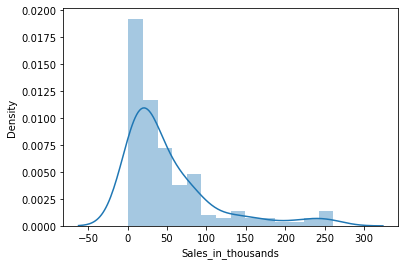

In [ ]:
# Very first assumtion is that all the variables should be normally distributed, however that can't be possible
# However we have to be atleast strict about the dependant Y variable

# Distribution of variables
sns.distplot(cars_new.Sales_in_thousands)
plt.show()
# this distribution is highly skewed

# Notes:
#-----------------------------------------------------
# 1. if we get skewed data, then we have to transform the data and there are multiple methods to go about it
# 2. most commonly used and which works on most of the data is log transformation
# 3. Ideally we can do this for each of the dependant variable as well, 
#    however it will depend on amount of data and the amount of analytical rigour
# 4. In no case we can proceed if dependant variable is not normal/near to normal distributed

In [ ]:
cars_new.Sales_in_thousands.skew()

1.9924932920508793

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


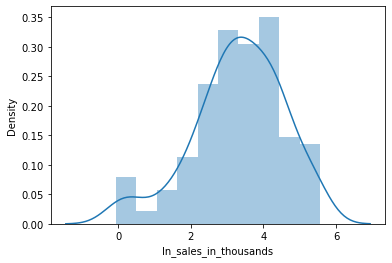

In [ ]:
# Note: good practice is to take the log of the data plus 1, bcoz we don't have log of zero defined
# In thios data its not required as sales are always greater than zero

# apply log transformation: log is rescalling the data and making the distribution normal
cars_new.loc[:, 'ln_sales_in_thousands'] = np.log(cars_new.loc[:, 'Sales_in_thousands'])

# Distribution of variables
sns.distplot(cars_new.ln_sales_in_thousands)
plt.show()

In [ ]:
cars_new.ln_sales_in_thousands.skew()

-0.5925861100519006

In [ ]:
# Linearity: correlation matrix (ranges from 1 to -1)
corrm = cars_new.corr()
corrm.to_excel('D:/corrm.xlsx')
corrm

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,...,Manufacturer_Pontiac,Manufacturer_Porsche,Manufacturer_Saab,Manufacturer_Saturn,Manufacturer_Subaru,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Vehicle_type_Passenger,ln_sales_in_thousands
Sales_in_thousands,1.000000,-3.075381e-01,-0.361572,-0.014342,-0.259311,0.278280,0.093054,0.200997,-0.035282,0.044446,...,0.036853,-0.114192,-7.988584e-02,-0.054683,-2.181588e-02,0.133404,-0.056294,-1.333610e-01,-0.230252,0.799513
four_year_resale_value,-0.307538,1.000000e+00,0.832320,0.440258,0.679605,-0.037624,0.158211,0.025517,0.304378,0.284274,...,-0.071303,0.512245,4.484484e-17,-0.087128,5.774589e-17,-0.030552,-0.062450,2.124397e-16,0.076638,-0.479350
Price_in_thousands,-0.361572,8.323203e-01,1.000000,0.618230,0.849851,0.118080,0.328107,0.158161,0.527230,0.430942,...,-0.062676,0.352160,1.860392e-02,-0.170025,-4.839044e-02,-0.094643,-0.137820,5.158511e-02,0.042006,-0.578170
Engine_size,-0.014342,4.402582e-01,0.618230,1.000000,0.815010,0.518423,0.702618,0.576386,0.793937,0.698341,...,0.078278,0.016675,-1.047543e-01,-0.191415,-6.401942e-02,-0.108099,-0.221271,-1.531916e-01,-0.279272,-0.120983
Horsepower,-0.259311,6.796053e-01,0.849851,0.815010,1.000000,0.325247,0.538115,0.420472,0.637823,0.526554,...,-0.001225,0.231413,-1.693190e-02,-0.227139,-4.398854e-02,-0.115857,-0.244956,-1.198690e-02,-0.011910,-0.400528
Wheelbase,0.278280,-3.762379e-02,0.118080,0.518423,0.325247,1.000000,0.681402,0.837566,0.657133,0.659706,...,0.046301,-0.260846,-4.521823e-02,-0.083508,-9.218360e-02,-0.094079,-0.203652,-8.565596e-02,-0.383084,0.270203
Width,0.093054,1.582115e-01,0.328107,0.702618,0.538115,0.681402,1.000000,0.700153,0.710589,0.648557,...,0.042237,-0.060887,-7.315767e-02,-0.200799,-1.102499e-01,-0.115710,-0.187554,-9.484845e-02,-0.241472,0.038309
Length,0.200997,2.551744e-02,0.158161,0.576386,0.420472,0.837566,0.700153,1.000000,0.622789,0.561884,...,0.096592,-0.149884,-1.422854e-02,-0.061395,-5.953822e-02,-0.103610,-0.304533,-5.911793e-02,-0.129701,0.207226
Curb_weight,-0.035282,3.043781e-01,0.527230,0.793937,0.637823,0.657133,0.710589,0.622789,1.000000,0.868131,...,0.007662,-0.094627,-4.503929e-02,-0.221474,-2.013658e-02,-0.070768,-0.161960,-3.058882e-02,-0.519405,-0.051904
Fuel_capacity,0.044446,2.842737e-01,0.430942,0.698341,0.526554,0.659706,0.648557,0.561884,0.868131,1.000000,...,-0.001650,-0.034864,-7.424594e-03,-0.260342,-4.633177e-02,-0.011787,-0.170589,-6.026328e-03,-0.594758,-0.019549


<AxesSubplot:>

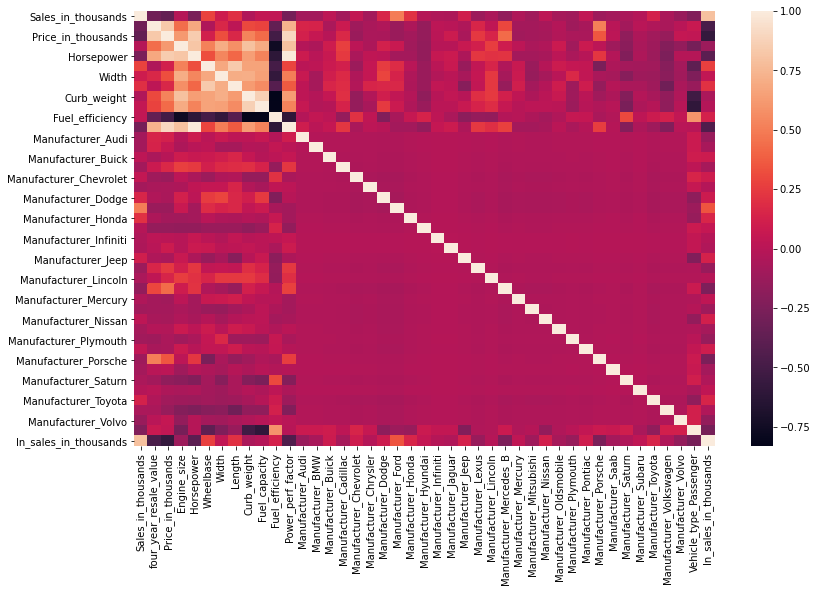

In [ ]:
# visualize correlation matrix in Seaborn using a heatmap
plt.figure(figsize = (13, 8))
sns.heatmap(cars_new.corr())

# fuel efficiency vs fuel capacity
# Curb weight vs Engine Size

# in case we can't make any concrete decision looking at the variables;
# we can also check on the VAR of the variables into consideration e.g Curb weight vs Wheel base

In [ ]:
# no of variables and obs in the final data to be used for modelling
cars_new.shape

(157, 43)

### split the data for model building

In [ ]:
# tuple unpacking
a, b = 10, 20

In [ ]:
cars_new.shape

(157, 43)

In [ ]:
# method 1: divide the data into training and testing
train, test = train_test_split( cars_new, test_size = 0.3, random_state = 12345 )

In [ ]:
# method 2: divide the data into training and testing and separate out Y and X variables
# this will be used in sklearn related methods
train_X, test_X, train_y, test_y = train_test_split( cars_new[feature_columns], 
                        cars_new['ln_sales_in_thousands'], test_size = 0.3, random_state = 12345)

In [ ]:
# verify the no of obs in training and testing after split
print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  109  |  No of obs in testing:  48


## Form of linear regression

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$

- $y$ is the response
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for $x_1$ (the first feature)
- $\beta_n$ is the coefficient for $x_n$ (the nth feature)

The $\beta$ values are called the **model coefficients**:

- These values are estimated (or "learned") during the model fitting process using the **least squares criterion**.
- Specifically, we are find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors").
- And once we've learned these coefficients, we can use the model to predict the response.

### building a linear regression model

## model 0

In [ ]:
# manual method of defining the model equation
m1_equation = '''ln_sales_in_thousands ~ Fuel_efficiency + Length + Price_in_thousands + 
            Vehicle_type_Passenger + Manufacturer_Ford'''

In [ ]:
lm0 = smf.ols( formula = m1_equation, data = train ).fit()

In [ ]:
print(lm0.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_sales_in_thousands   R-squared:                       0.526
Model:                               OLS   Adj. R-squared:                  0.503
Method:                    Least Squares   F-statistic:                     22.83
Date:                   Sun, 12 Sep 2021   Prob (F-statistic):           2.33e-15
Time:                           16:33:55   Log-Likelihood:                -139.86
No. Observations:                    109   AIC:                             291.7
Df Residuals:                        103   BIC:                             307.9
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

### Model 1

In [ ]:
cars_new.shape

(157, 43)

In [ ]:
cars_new.columns.difference( [ 'Sales_in_thousands', 'ln_sales_in_thousands' ] )

Index(['Curb_weight', 'Engine_size', 'Fuel_capacity', 'Fuel_efficiency',
       'Horsepower', 'Length', 'Manufacturer_Audi', 'Manufacturer_BMW',
       'Manufacturer_Buick', 'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes_B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Power_perf_factor', 'Price_in_thousands', 'Vehicle_type_Passenger',
       'Wheelbase', 'Width', 'four_year_resale_value'],
      dtype

In [ ]:
model_eq2 = 'ln_sales_in_thousands ~ ' + ' + '.join( cars_new.columns.difference( [ 'Sales_in_thousands', 'ln_sales_in_thousands' ] ) )

In [ ]:
model_eq2

'ln_sales_in_thousands ~ Curb_weight + Engine_size + Fuel_capacity + Fuel_efficiency + Horsepower + Length + Manufacturer_Audi + Manufacturer_BMW + Manufacturer_Buick + Manufacturer_Cadillac + Manufacturer_Chevrolet + Manufacturer_Chrysler + Manufacturer_Dodge + Manufacturer_Ford + Manufacturer_Honda + Manufacturer_Hyundai + Manufacturer_Infiniti + Manufacturer_Jaguar + Manufacturer_Jeep + Manufacturer_Lexus + Manufacturer_Lincoln + Manufacturer_Mercedes_B + Manufacturer_Mercury + Manufacturer_Mitsubishi + Manufacturer_Nissan + Manufacturer_Oldsmobile + Manufacturer_Plymouth + Manufacturer_Pontiac + Manufacturer_Porsche + Manufacturer_Saab + Manufacturer_Saturn + Manufacturer_Subaru + Manufacturer_Toyota + Manufacturer_Volkswagen + Manufacturer_Volvo + Power_perf_factor + Price_in_thousands + Vehicle_type_Passenger + Wheelbase + Width + four_year_resale_value'

In [ ]:
lm1 = smf.ols( formula = model_eq2, data = train ).fit()

In [ ]:
print( lm1.summary() )

                              OLS Regression Results                             
Dep. Variable:     ln_sales_in_thousands   R-squared:                       0.700
Model:                               OLS   Adj. R-squared:                  0.531
Method:                    Least Squares   F-statistic:                     4.136
Date:                   Sun, 12 Sep 2021   Prob (F-statistic):           1.36e-07
Time:                           17:02:31   Log-Likelihood:                -114.83
No. Observations:                    109   AIC:                             309.7
Df Residuals:                         69   BIC:                             417.3
Df Model:                             39                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------